[4.792033473775244, 5.1560470041927235, 5.474083168138346, 6.297242604400777, 6.806037240465031, 6.86464590523416, 7.112875690269118, 7.14461717266561, 7.789775650642977, 8.064287668233561, 8.802778854006416, 9.088776497613585, 9.119703713622545, 9.151842346049886, 9.380554046966065, 19.193253317393477, 20.547350718100517, 22.229965563826973, 23.450152609790955, 24.81354222734037, 25.723780855216013, 25.777587967999477, 28.62294122679509, 30.2443264993474, 31.416434702114664, 31.879144517016968, 32.520660516027704, 33.874968246742775, 36.404733736145516]


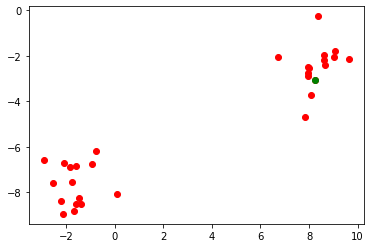

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
import random
import math
import matplotlib.pyplot as plt
from no_cluster import get_cluster
import copy

In [2]:
#random.seed(15)
P=2 #signal power threshold
#stream = BitStream()
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 30
        self.rounds = 200
        self.epochs = 2
        self.local_batches = 64
        self.lr = 0.01
        self.C = 0.9 #fraction of clients used in the round
        self.drop_rate = 0.1 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.csi_low=0
        self.csi_high=1
 
args = Arguments()

In [4]:
#checking if gpu is available
use_cuda = False
#print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
clients = []

#generating virtual clients
for i in range(int(args.clients)):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
    
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

In [5]:
for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average

#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 128)  #10 iid 50 non iid
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data,target=data,target
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get() 
    #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [8]:
def test(args, model, device, test_loader, name):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(100. * correct / len(test_loader.dataset))


In [9]:
torch.manual_seed(args.torch_seed)
#global_model = Net() #redundant code as we don't use it for training: assigns a CNN to the global model

for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    

accuracy=[]
rc=1

[7.13220226641212, 7.693212254323608, 7.839881799697711, 8.031758123585778, 8.333681916433473, 9.217576437049779, 10.206599642321356, 10.228036385508574, 10.495509422151986, 10.574175352439738, 11.414721836905116, 11.43683245745521, 11.523803357394542, 11.535836537278499, 12.131396295549962, 16.19816914861419, 16.64600190538016, 17.846825708184685, 18.025123029065334, 18.07647794468584, 21.20503271730755, 21.74536151487196, 23.73023504801961, 24.81936364339352, 25.927790988832008, 26.1899990489482, 28.451861435887853, 30.709416114024773, 35.003162289336125]


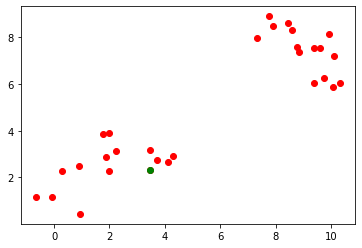

Power Allocated= 2.8779093570895613
CSI= 0.8633679825702657
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8758237594125466
CSI= 0.86181616341432
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2398301050281807
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.419502356526782
CSI= 0.38216633439842496
SNR= 8.031758123585778
Client: client4
Model client4 Train Epoch: 1 [0/384 (0%)]	Loss: 2.298856


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client4 Train Epoch: 2 [0/384 (0%)]	Loss: 2.141226

Power Allocated= 2.314033857674217
CSI= 0.5806761975604982
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.304167
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 2.292115

Power Allocated= 2.5968615280520138
CSI= 0.694780978182411
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.19899821616644908
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.987486949649865
CSI= 0.9535823934912836
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 2.298682
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 2.293041

Power Allocated= 1.6042258039218567
CSI= 0.411194655109834
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.750431827548775
CSI= 0.77776693958

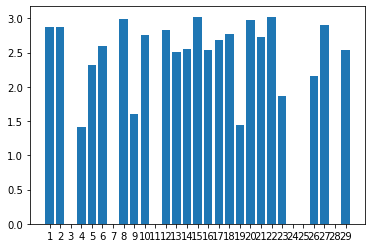

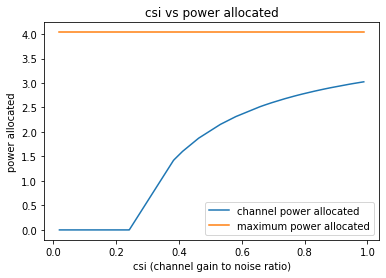

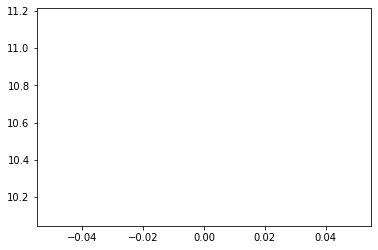

1
Power Allocated= 0
CSI= 0.2140836639648389
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13703870551973896
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.175966572371018
CSI= 0.8574889216621255
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.629274312514182
CSI= 0.5838093037898039
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7872853069675494
CSI= 0.6431376515169549
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.17835301945094528
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.350533871182106
CSI= 0.5021016655967815
SNR= 10.206599642321356
Client: clien

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 2.289684

Power Allocated= 0
CSI= 0.2040629955561366
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.207922948038277
CSI= 0.8816480514995458
SNR= 10.495509422151986
Client: client10
Model client10 Train Epoch: 1 [0/384 (0%)]	Loss: 2.306402
Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 2.282147

Power Allocated= 1.822577830413985
CSI= 0.39689082609557247
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 2.303506
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 2.296282

Power Allocated= 3.099470994504392
CSI= 0.8047050121157225
SNR= 11.414721836905116
Client: client12
Model client12 Train Epoch: 1 [0/384 (0%)]	Loss: 2.297787
Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 2.294000

Power Allocated= 2.2574164692471657
CSI= 0.47967475880301236
SNR= 11.43683245745521
Client: client13
Model client13 Train Epoch: 1 [0/384 (0%)]	Los

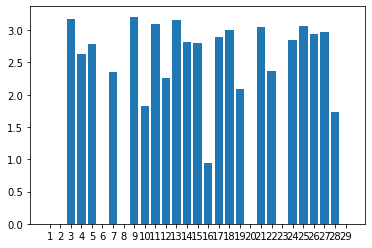

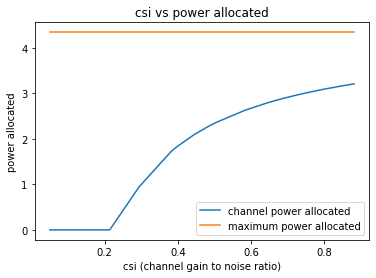

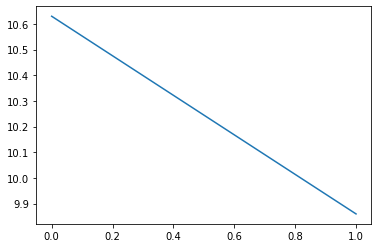

2
Power Allocated= 4.194870928931574
CSI= 0.962383332270188
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1804822362774265
CSI= 0.2467018623715117
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.0999676642055225
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.7266982512406175
CSI= 0.6634556880970532
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.11766101333880685
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7839242850607344
CSI= 0.40815766206479254
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.8393173666756271
CSI= 0.2275498958557537
SNR= 10.20659964232

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 2.291122

Power Allocated= 0.7916587916050943
CSI= 0.2251086591260818
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 2.292689
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 2.207826

Power Allocated= 2.3493841841711602
CSI= 0.34667167212030914
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 4.064449738276093
CSI= 0.8550602864525195
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.09998129887237794
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.83700508244518
CSI= 0.7158437807260349
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.18194826830477684
SNR= 11.523803357394542
Client: client14
Poor Channel, cli

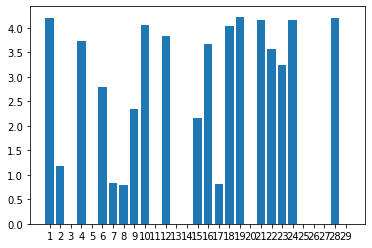

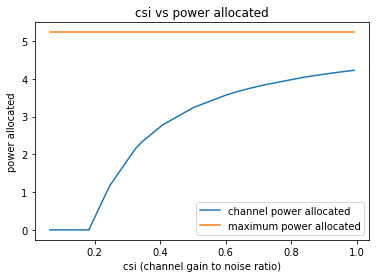

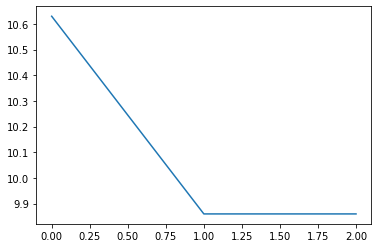

3
Power Allocated= 0
CSI= 0.03589345555221868
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3750512722318073
CSI= 0.44101933896632184
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.6278861218439484
CSI= 0.9855718081980234
SNR= 7.839881799697711
Client: client3
Model client3 Train Epoch: 1 [0/384 (0%)]	Loss: 2.301563
Model client3 Train Epoch: 2 [0/384 (0%)]	Loss: 2.300185


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform


Power Allocated= 0.26179639128695786
CSI= 0.22827250155110324
SNR= 8.031758123585778
Client: client4
Model client4 Train Epoch: 1 [0/384 (0%)]	Loss: 2.304312
Model client4 Train Epoch: 2 [0/384 (0%)]	Loss: 2.297847

Power Allocated= 0.7623572613225327
CSI= 0.25772078161396406
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.305427
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 2.298578

Power Allocated= 3.3346451853886885
CSI= 0.7645959365818712
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 2.302956
Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 2.301947

Power Allocated= 2.9153955786188614
CSI= 0.5789952267040298
SNR= 10.206599642321356
Client: client8
Model client8 Train Epoch: 1 [0/384 (0%)]	Loss: 2.302415
Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 2.297955

Power Allocated= 3.585662283667906
CSI= 0.9461962082503045
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)

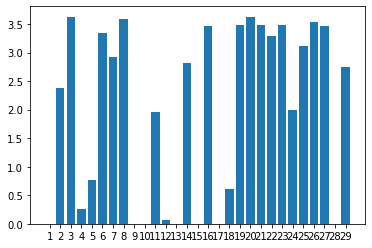

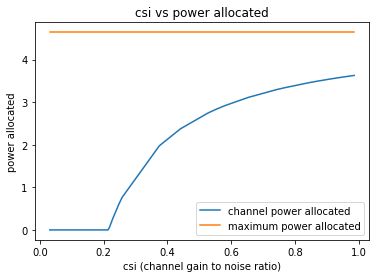

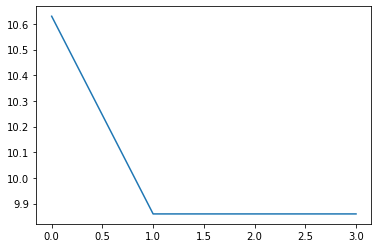

4
Power Allocated= 0
CSI= 0.05307030607795682
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5322138935321292
CSI= 0.44170602882582055
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.591055704944827
CSI= 0.8298015839709257
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.4024576387484773
CSI= 0.2275983257755133
SNR= 8.031758123585778
Client: client4
Model client4 Train Epoch: 1 [0/384 (0%)]	Loss: 2.306354
Model client4 Train Epoch: 2 [0/384 (0%)]	Loss: 2.270802


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform


Power Allocated= 0
CSI= 0.02003236477619963
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.923320628646956
CSI= 0.5339477460371163
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.010055023816728847
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07115776546592989
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8791783230601826
CSI= 0.5216525597472083
SNR= 10.495509422151986
Client: client10
Model client10 Train Epoch: 1 [0/384 (0%)]	Loss: 2.301997
Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 2.296175

Power Allocated= 0
CSI= 0.08763825911138223
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.494181501789744
CSI= 0.7680

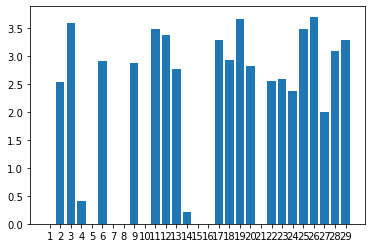

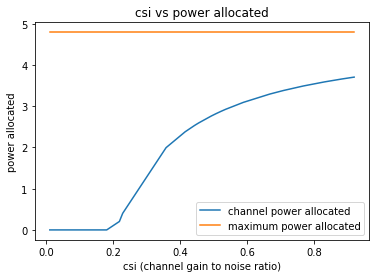

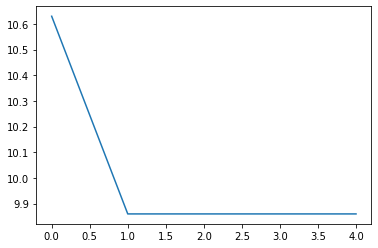

5
Power Allocated= 2.3061542406893025
CSI= 0.5152377387343251
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5456850641896605
CSI= 0.5877786258488612
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07430348831458178
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1394655095407384
CSI= 0.47448676338271634
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.485690142890484
CSI= 0.5677573814806894
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.298547
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 2.296219


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform


Power Allocated= 3.140916439567839
CSI= 0.9040860356697535
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 2.297387
Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 2.303529

Power Allocated= 2.2080987913975942
CSI= 0.49045884188310784
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.873592108764063
CSI= 0.7281127034498568
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07963219641033492
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6171578927799217
CSI= 0.6135541593936138
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 2.301706
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 2.296482

Power Allocated= 1.373634427832802
CSI= 0.3480232275238756
SNR= 11.414721836905116
Client: client12
Mod

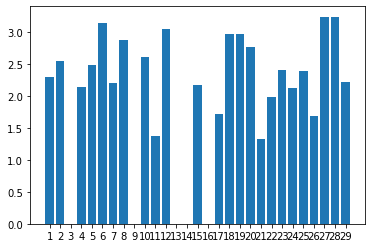

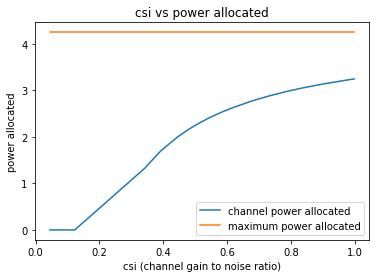

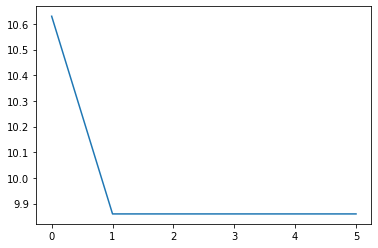

6
Power Allocated= 2.239681917446411
CSI= 0.39668959535969783
SNR= 7.13220226641212
Client: client1
Model client1 Train Epoch: 1 [0/384 (0%)]	Loss: 2.301429
Model client1 Train Epoch: 2 [0/384 (0%)]	Loss: 2.302621


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 3.2783482979317924
CSI= 0.6746744640719694
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.6421706555591413
CSI= 0.8941553040774998
SNR= 7.839881799697711
Client: client3
Model client3 Train Epoch: 1 [0/384 (0%)]	Loss: 2.303670
Model client3 Train Epoch: 2 [0/384 (0%)]	Loss: 2.297078

Power Allocated= 1.9267993494877422
CSI= 0.35288987166184327
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.5606474982817877
CSI= 0.23810107111673495
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.15135601467972815
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.05710551661409913
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real



Power Allocated= 3.7149147919528582
CSI= 0.9563614065664441
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.297182472585623
CSI= 0.6833578489963347
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07561314591665436
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.268380761562998
CSI= 0.4012577271396075
SNR= 11.43683245745521
Client: client13
Model client13 Train Epoch: 1 [0/384 (0%)]	Loss: 2.291538
Model client13 Train Epoch: 2 [0/384 (0%)]	Loss: 2.174335

Power Allocated= 3.3870051881009067
CSI= 0.7280460879009495
SNR= 11.523803357394542
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0952342858627753
CSI= 0.3751908332515361
SNR= 11.535836537278499
Client: client15
Poor Channel, client not taken for averaging in this ro

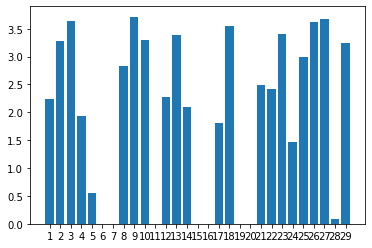

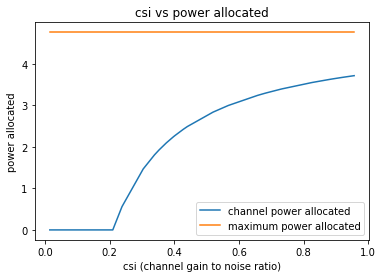

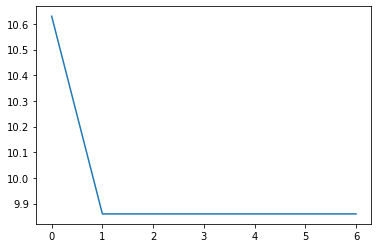

7
Power Allocated= 1.6314867690537862
CSI= 0.33789949488989357
SNR= 7.13220226641212
Client: client1
Model client1 Train Epoch: 1 [0/384 (0%)]	Loss: 2.293720
Model client1 Train Epoch: 2 [0/384 (0%)]	Loss: 2.299863


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 0
CSI= 0.1794875927839108
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.14104278647363078
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.53889330158236
CSI= 0.9505221369830152
SNR= 8.031758123585778
Client: client4
Model client4 Train Epoch: 1 [0/384 (0%)]	Loss: 2.300653
Model client4 Train Epoch: 2 [0/384 (0%)]	Loss: 2.280576


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real



Power Allocated= 2.5286354805996956
CSI= 0.48489287809026405
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.2057112242366701
CSI= 0.22803792776898602
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 2.300337
Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 2.293378

Power Allocated= 2.751583940958206
CSI= 0.5436665608932915
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.10980069618458865
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.812364570042492
CSI= 0.562245627834366
SNR= 10.495509422151986
Client: client10
Model client10 Train Epoch: 1 [0/384 (0%)]	Loss: 2.301245
Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 2.295050

Power Allocated= 0
CSI= 0.15047435925402997
SNR= 10.574175352439738
Client: client11
Poor Channel, client

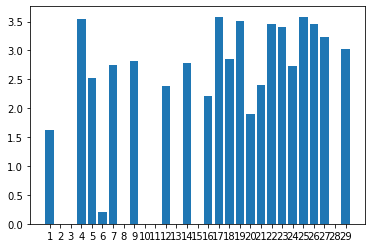

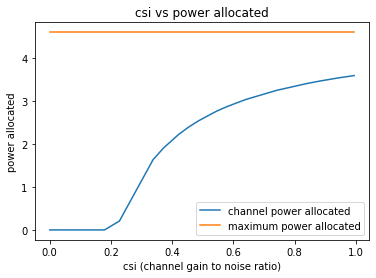

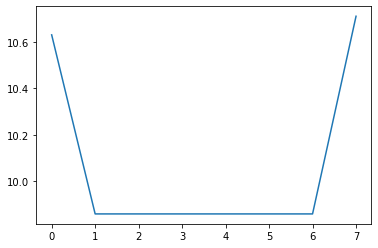

8
Power Allocated= 3.462107643154418
CSI= 0.9269507311820291
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4472078534800854
CSI= 0.9143226814756396
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1482787408671506
CSI= 0.7180632960542569
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.465550415159833
CSI= 0.9299183610751315
SNR= 8.031758123585778
Client: client4
Model client4 Train Epoch: 1 [0/384 (0%)]	Loss: 2.301356
Model client4 Train Epoch: 2 [0/384 (0%)]	Loss: 2.270346


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 3.1890103009382953
CSI= 0.7396978594212807
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4701713880489526
CSI= 0.9339315842019933
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.18055533194889217
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4772826999089976
CSI= 0.940175741410974
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9256585184683512
CSI= 0.6190972507884995
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.224460979063341
CSI= 0.7596171407331885
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.6774922348456509
CSI= 0.25883793074769

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 2.255105

Power Allocated= 0
CSI= 0.21770433053136595
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5412590127407442
CSI= 0.3333717134094297
SNR= 11.523803357394542
Client: client14
Model client14 Train Epoch: 1 [0/384 (0%)]	Loss: 2.292071
Model client14 Train Epoch: 2 [0/384 (0%)]	Loss: 2.299298

Power Allocated= 0
CSI= 0.08838053108920041
SNR= 11.535836537278499
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4888813073663023
CSI= 0.48732175808424816
SNR= 12.131396295549962
Client: client16
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.067028894658379
CSI= 0.6784791068015724
SNR= 16.19816914861419
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.0673762150457229
CSI= 0.28789095380690033
SNR= 16.64600190538016
Client: client18
Model client

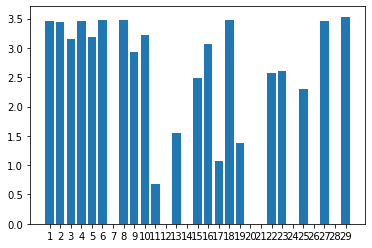

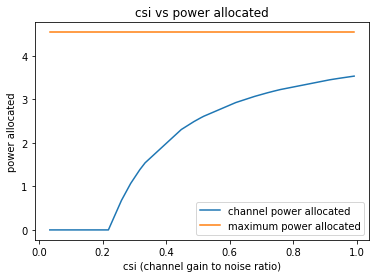

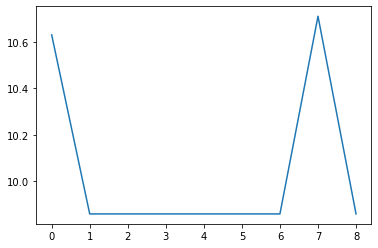

9
Power Allocated= 2.8148822859236233
CSI= 0.47704765302496055
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.6865046986714503
CSI= 0.81659035280701
SNR= 7.693212254323608
Client: client2
Model client2 Train Epoch: 1 [0/384 (0%)]	Loss: 2.298068
Model client2 Train Epoch: 2 [0/384 (0%)]	Loss: 2.294788


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 0.6235694802555569
CSI= 0.23323400567979236
SNR= 7.839881799697711
Client: client3
Model client3 Train Epoch: 1 [0/384 (0%)]	Loss: 2.287431
Model client3 Train Epoch: 2 [0/384 (0%)]	Loss: 2.270123

Power Allocated= 3.124256716935161
CSI= 0.5596433737417288
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.16786667821310908
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.8787139388884038
CSI= 0.9686215161472537
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.04456675010541611
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.027329558969677037
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.029806083

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client13 Train Epoch: 2 [0/384 (0%)]	Loss: 2.007759

Power Allocated= 3.741899476515952
CSI= 0.8552787512893852
SNR= 11.523803357394542
Client: client14
Model client14 Train Epoch: 1 [0/384 (0%)]	Loss: 2.300643
Model client14 Train Epoch: 2 [0/384 (0%)]	Loss: 2.291238

Power Allocated= 3.5466462472576294
CSI= 0.7328892272564429
SNR= 11.535836537278499
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7356267018041285
CSI= 0.45966820035411393
SNR= 12.131396295549962
Client: client16
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1346687161851996
CSI= 0.26479963770285464
SNR= 16.19816914861419
Client: client17
Model client17 Train Epoch: 1 [0/384 (0%)]	Loss: 2.298198
Model client17 Train Epoch: 2 [0/384 (0%)]	Loss: 2.274361

Power Allocated= 0
CSI= 0.17754448349258456
SNR= 16.64600190538016
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.1296369969422

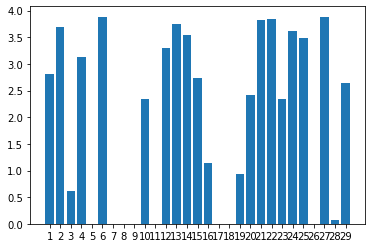

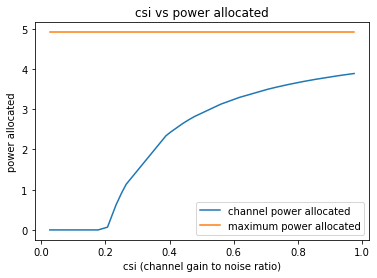

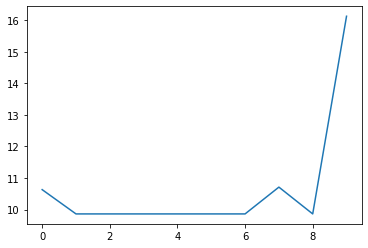

10
Power Allocated= 0
CSI= 0.17137426274952527
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.545188156574127
CSI= 0.4582846005209642
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.01734875794368007
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5919932893979225
CSI= 0.4683303194039191
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4169814177476763
CSI= 0.76320909082888
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.555562164449084
CSI= 0.8534781320871901
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.712819225687368
CSI= 0.985785834116858
SNR= 10.20659964232135

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 2.216159

Power Allocated= 0
CSI= 0.09574186442974619
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.17589574602777658
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6979408738144781
CSI= 0.33010954148068794
SNR= 11.414721836905116
Client: client12
Model client12 Train Epoch: 1 [0/384 (0%)]	Loss: 2.297627
Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 2.284380

Power Allocated= 3.2645941650595223
CSI= 0.6836932810471151
SNR= 11.43683245745521
Client: client13
Model client13 Train Epoch: 1 [0/384 (0%)]	Loss: 2.274458
Model client13 Train Epoch: 2 [0/384 (0%)]	Loss: 2.205721

Power Allocated= 3.473280492033871
CSI= 0.7974749675631292
SNR= 11.523803357394542
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.98622581276607
CSI= 0.574378403446985

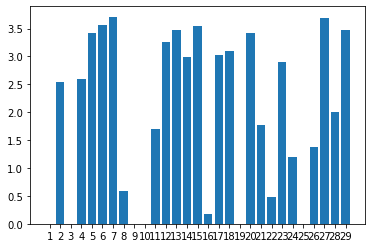

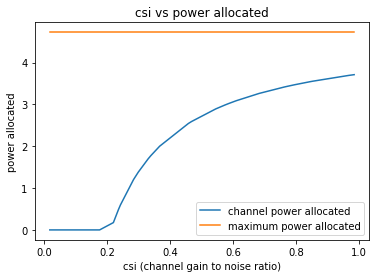

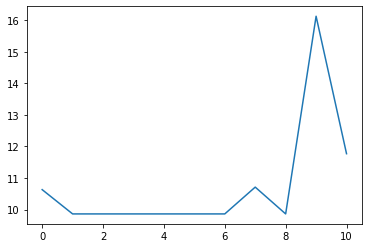

11
Power Allocated= 3.4269782193905947
CSI= 0.7892809536718659
SNR= 7.13220226641212
Client: client1
Model client1 Train Epoch: 1 [0/384 (0%)]	Loss: 2.244990
Model client1 Train Epoch: 2 [0/384 (0%)]	Loss: 2.167847


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 2.0615492151621053
CSI= 0.37988075949384537
SNR= 7.693212254323608
Client: client2
Model client2 Train Epoch: 1 [0/384 (0%)]	Loss: 2.238814
Model client2 Train Epoch: 2 [0/384 (0%)]	Loss: 2.190499

Power Allocated= 0
CSI= 0.2016900076024808
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0628728167072854
CSI= 0.3800718637165904
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3417529783149567
CSI= 0.7395349106120945
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.259403
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 2.192772


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real



Power Allocated= 3.4731449433548605
CSI= 0.8191287911680817
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.381070799851277
CSI= 0.4323607517582376
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5314538317110538
CSI= 0.4624276696883681
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 2.240704
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 1.863878

Power Allocated= 1.9991335370881322
CSI= 0.37108220913696954
SNR= 10.495509422151986
Client: client10
Model client10 Train Epoch: 1 [0/384 (0%)]	Loss: 2.232842
Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 2.142835

Power Allocated= 2.366478300059811
CSI= 0.42964999362954903
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.20921424481614448
CSI= 0.22297836951307748
SNR= 11.414721836905116


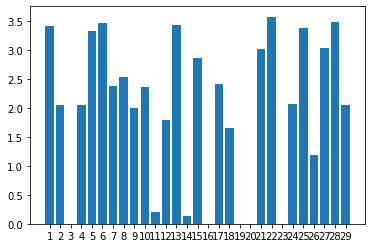

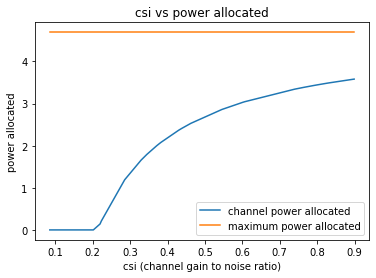

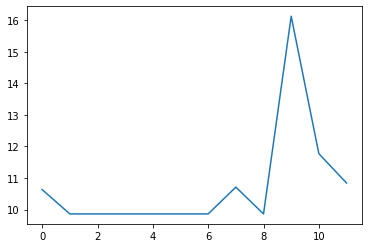

12
Power Allocated= 3.2271412661635885
CSI= 0.8538471663397348
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9953918748783308
CSI= 0.4161604813651558
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.10217504298051683
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.7250678721956967
CSI= 0.37407745350008315
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.38817089784805
CSI= 0.9899616397758265
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.143574


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 1.589351

Power Allocated= 0
CSI= 0.08215008406632385
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.580138002398532
CSI= 0.5500026535496313
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2058458986918965
CSI= 0.8385989310567893
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06742030162535739
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7988673767079244
CSI= 0.27782071096727934
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6192203717409113
CSI= 0.56208489709428
SNR= 11.414721836905116
Client: client12
Model client12 Train Epoch: 1 [0/384 (0%)]	Loss: 2.154086
Model client12 T

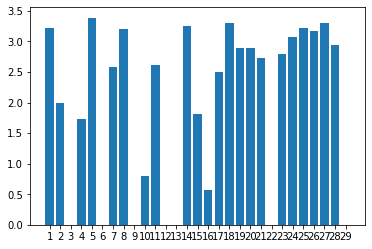

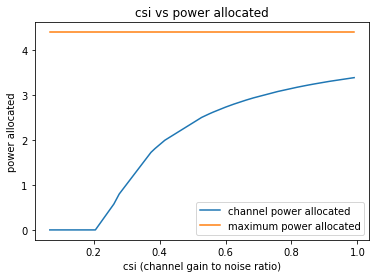

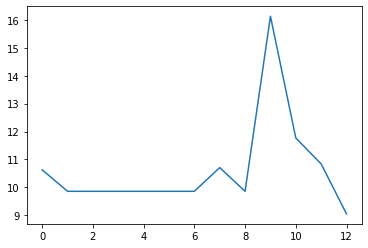

13
Power Allocated= 0.8184025398161325
CSI= 0.2661104871430281
SNR= 7.13220226641212
Client: client1
Model client1 Train Epoch: 1 [0/384 (0%)]	Loss: 1.791770
Model client1 Train Epoch: 2 [0/384 (0%)]	Loss: 1.457408


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 0
CSI= 0.1283364233723593
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2433751240872546
CSI= 0.7502635092396185
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2530855659812863
CSI= 0.7557695855806964
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.377617854233313
CSI= 0.8342911643513569
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.095542
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 2.238437


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real



Power Allocated= 0.16731004074286293
CSI= 0.22681239500403272
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 2.109269
Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 1.949926

Power Allocated= 1.4130573125923758
CSI= 0.3161372730877199
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4390753392515068
CSI= 0.8793799991003148
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.14971750425988517
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.918214328916393
CSI= 0.6031269118965629
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2898988290947644
CSI= 0.7773986383952555
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this roun

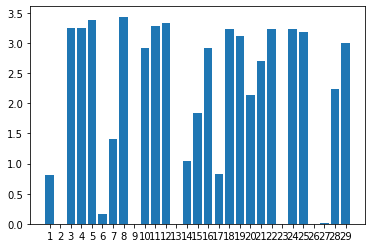

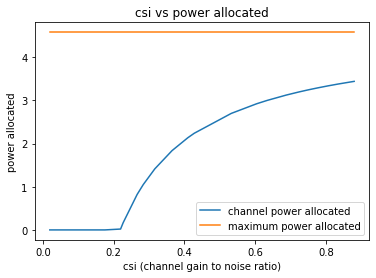

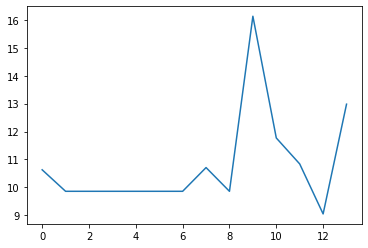

14
Power Allocated= 1.11983075900209
CSI= 0.3012516574829568
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6903671103640407
CSI= 0.5717724649686586
SNR= 7.693212254323608
Client: client2
Model client2 Train Epoch: 1 [0/384 (0%)]	Loss: 2.137819
Model client2 Train Epoch: 2 [0/384 (0%)]	Loss: 1.183182


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 3.3358418903452383
CSI= 0.9062299580141588
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7048666072551248
CSI= 0.2677771949218124
SNR= 8.031758123585778
Client: client4
Model client4 Train Epoch: 1 [0/384 (0%)]	Loss: 2.129897
Model client4 Train Epoch: 2 [0/384 (0%)]	Loss: 1.282398

Power Allocated= 2.816898768657967
CSI= 0.6163648056663945
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.069562
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 1.173961

Power Allocated= 3.121538702926954
CSI= 0.7588543887584667
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.429962516616497
CSI= 0.990734597324539
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0975145027521522
CSI= 0.7452675137937396
SNR= 10.228036385508574
Client: clien

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real



Power Allocated= 3.202120476448087
CSI= 0.8082806128388421
SNR= 16.64600190538016
Client: client18
Model client18 Train Epoch: 1 [0/384 (0%)]	Loss: 2.103170
Model client18 Train Epoch: 2 [0/384 (0%)]	Loss: 1.653546

Power Allocated= 0.6063236359122057
CSI= 0.2608928685823054
SNR= 17.846825708184685
Client: client19
Model client19 Train Epoch: 1 [0/384 (0%)]	Loss: 2.111230
Model client19 Train Epoch: 2 [0/384 (0%)]	Loss: 1.622388

Power Allocated= 0.5769712750579545
CSI= 0.2589101806028883
SNR= 18.025123029065334
Client: client20
Model client20 Train Epoch: 1 [0/384 (0%)]	Loss: 2.124019
Model client20 Train Epoch: 2 [0/384 (0%)]	Loss: 1.310900

Power Allocated= 2.901286638239444
CSI= 0.6501832505507927
SNR= 18.07647794468584
Client: client21
Model client21 Train Epoch: 1 [0/384 (0%)]	Loss: 2.101049
Model client21 Train Epoch: 2 [0/384 (0%)]	Loss: 1.530500

Power Allocated= 0
CSI= 0.18922157888494961
SNR= 21.20503271730755
Client: client22
Poor Channel, client not taken for averaging in

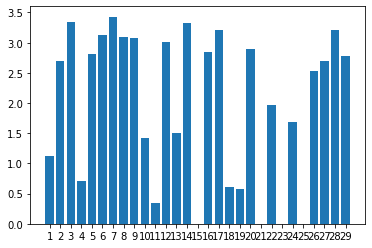

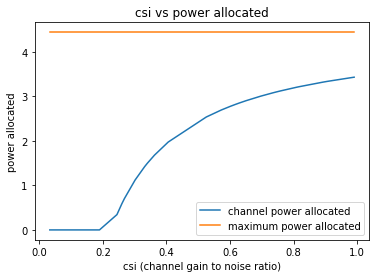

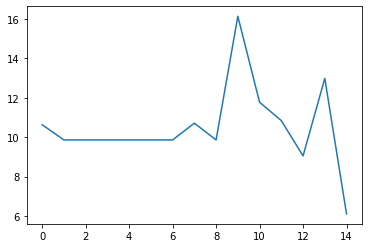

15
Power Allocated= 1.664328098570972
CSI= 0.40318772542833525
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8632717003738675
CSI= 0.780463053101245
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6376239543081934
CSI= 0.6635971406208859
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4140797620484453
CSI= 0.5778734880561597
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1328814778231813
CSI= 0.9884540106487563
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 1.683038
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 1.680747


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 0.9243281907409497
CSI= 0.3105364254414922
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 1.765179
Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 1.186436

Power Allocated= 3.0627609514785483
CSI= 0.9243841022533353
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.3831064948531906
CSI= 0.3621278261071269
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0290768768332748
CSI= 0.8964706741623879
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06466351257397451
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.129362109511768
CSI= 0.9850273627445231
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client13 Train Epoch: 2 [0/384 (0%)]	Loss: 1.700305

Power Allocated= 0
CSI= 0.04349657338096058
SNR= 11.523803357394542
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7261846817345003
CSI= 0.7050308486241835
SNR= 11.535836537278499
Client: client15
Model client15 Train Epoch: 1 [0/384 (0%)]	Loss: 1.432126
Model client15 Train Epoch: 2 [0/384 (0%)]	Loss: 1.224545

Power Allocated= 2.800558595175331
CSI= 0.7440455490937233
SNR= 12.131396295549962
Client: client16
Model client16 Train Epoch: 1 [0/384 (0%)]	Loss: 1.649152
Model client16 Train Epoch: 2 [0/384 (0%)]	Loss: 1.427500

Power Allocated= 2.8285647129249956
CSI= 0.7598797929569909
SNR= 16.19816914861419
Client: client17
Model client17 Train Epoch: 1 [0/384 (0%)]	Loss: 1.663037
Model client17 Train Epoch: 2 [0/384 (0%)]	Loss: 1.263134

Power Allocated= 0.7933204096459776
CSI= 0.2983968398902491
SNR= 16.64600190538016
Client: client18
Model client18 Train Epoch: 1 [0/384 (0%)]	L

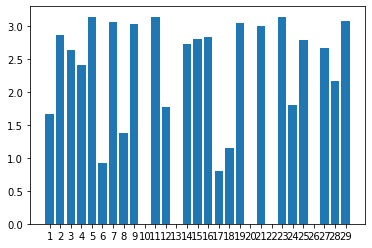

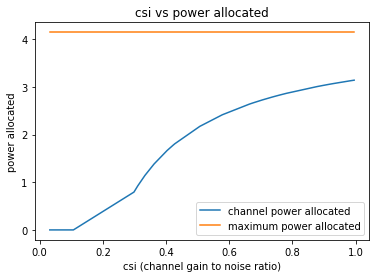

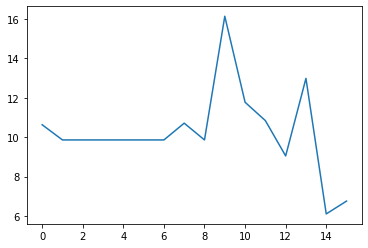

16
Power Allocated= 2.0889343557933473
CSI= 0.34647753344993637
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.0007255590028597547
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.8780464711725373
CSI= 0.9115122943198983
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.011334666657207948
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.16032286312242572
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.063067668809083
CSI= 0.5229970403784494
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.9669613267390336
CSI= 0.24949084834710544
SNR= 10.206599642321356
Clie

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 1.118281

Power Allocated= 3.3390279762874506
CSI= 0.6112109279662236
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06138766623729175
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.276409576002726
CSI= 0.37054675033436413
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 1.851766
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 1.272537

Power Allocated= 0
CSI= 0.046827474062544505
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.435806154756003
CSI= 0.6496382520706376
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1705646234401463
CSI= 0.554151779907724
SNR= 11.523803357394542
Client: client14
Poor Channel, 

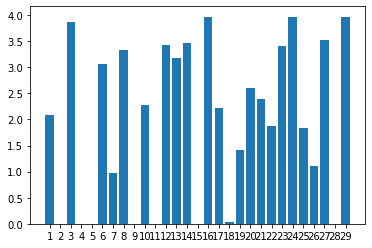

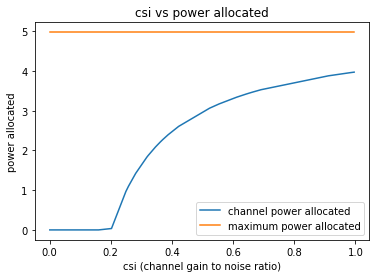

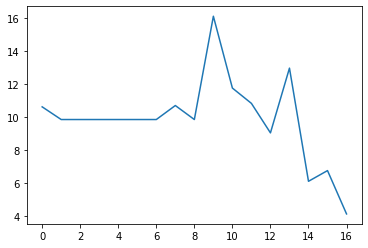

17
Power Allocated= 3.3346341759157916
CSI= 0.9494374708239331
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7804144381365212
CSI= 0.6220936612114479
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2714199547940734
CSI= 0.8956805595840839
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0184113465367934
CSI= 0.7302051895461468
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.114911943353071
CSI= 0.7855598502492056
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5965272127603387
CSI= 0.5582343945088611
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.5735608866341231
CSI= 0.26

/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad


Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 1.879782

Power Allocated= 2.706863528720119
CSI= 0.5948748333394615
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 1.948966
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 2.070989

Power Allocated= 0
CSI= 0.09344648336783845
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21272346097764372
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.14531689871469
CSI= 0.3083971111936724
SNR= 11.414721836905116
Client: client12
Model client12 Train Epoch: 1 [0/384 (0%)]	Loss: 1.835878
Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 1.417745


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real



Power Allocated= 3.165448145442635
CSI= 0.8180352026472743
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1487953499746961
CSI= 0.3087282977214807
SNR= 11.523803357394542
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3751668876563077
CSI= 0.987437291993498
SNR= 11.535836537278499
Client: client15
Model client15 Train Epoch: 1 [0/384 (0%)]	Loss: 1.825866
Model client15 Train Epoch: 2 [0/384 (0%)]	Loss: 1.455058

Power Allocated= 3.052960689561117
CSI= 0.7491036587291812
SNR= 12.131396295549962
Client: client16
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.16198130648516895
SNR= 16.19816914861419
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2208640944388055
SNR= 16.64600190538016
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated

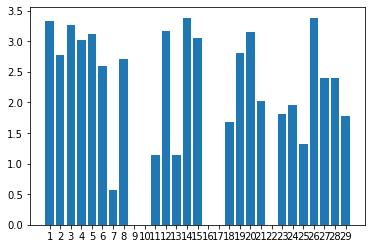

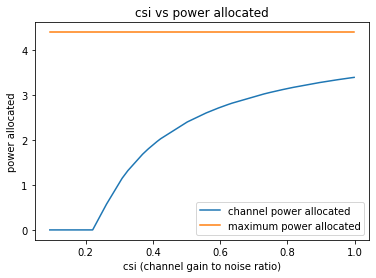

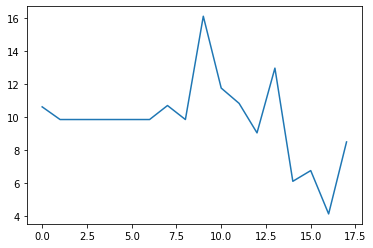

18
Power Allocated= 2.3580333442075236
CSI= 0.5069783731550166
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.008018103404372
CSI= 0.756151690640906
SNR= 7.693212254323608
Client: client2
Model client2 Train Epoch: 1 [0/384 (0%)]	Loss: 1.999368
Model client2 Train Epoch: 2 [0/384 (0%)]	Loss: 1.923538


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad
/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_


Power Allocated= 0
CSI= 0.09852747690470387
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4985061580317085
CSI= 0.5458521503212618
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8623106671417635
CSI= 0.6811091764845039
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 2.056420
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 1.541744

Power Allocated= 3.0655132880348983
CSI= 0.7905195940744583
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 1.995572
Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 1.976960

Power Allocated= 0
CSI= 0.04309546144392529
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.710660368525501
CSI= 0.617343512015065
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 

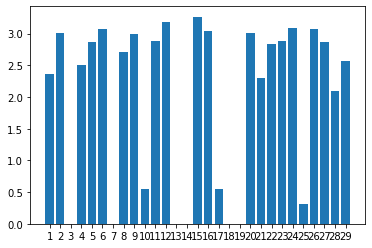

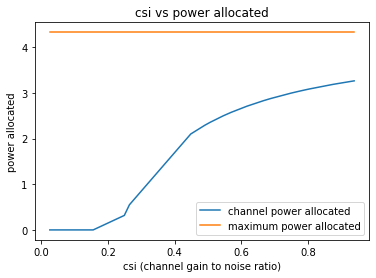

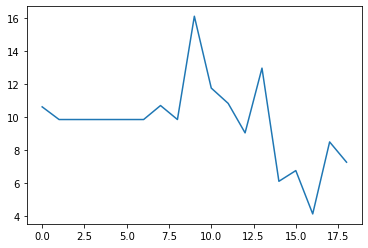

19
Power Allocated= 2.698419941590755
CSI= 0.6406615139503714
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.14669123454110566
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.9168603446893941
CSI= 0.29918207448579726
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.933007594659399
CSI= 0.7539778039243761
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5441594399005916
CSI= 0.5830403548303679
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8429546765148475
CSI= 0.7060392223768148
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.883737658952194
CSI= 0.7269719322275219
SN

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 1.085825

Power Allocated= 2.5381190008268852
CSI= 0.5809941979945427
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.15764139532214283
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0612227298239834
CSI= 0.8346661177119452
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 1.551678
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 0.983321

Power Allocated= 2.8035837330175077
CSI= 0.6869439458993057
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.987477917575997
CSI= 0.7862694289736009
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.928523275166662
CSI= 0.7514371368311465
SNR= 11.523803357394542
Client: client14

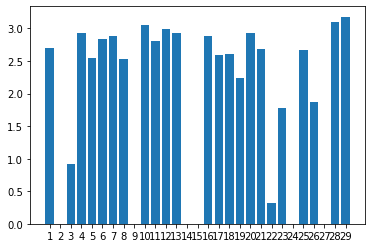

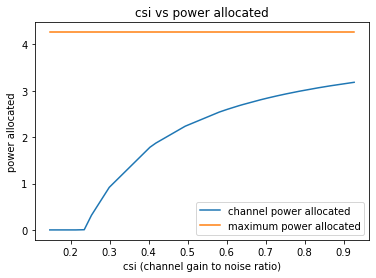

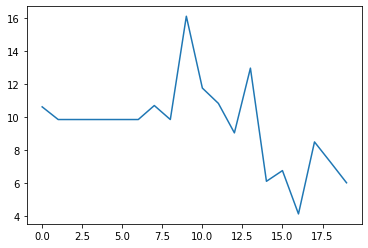

20
Power Allocated= 0
CSI= 0.09033305364246835
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.2652018880080016
CSI= 0.33411576826847145
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4567173248024385
CSI= 0.5551055686015128
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.04861226022005938
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.008302869102955523
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.18920488231642307
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.12099265547960714
SNR= 10.206599642321356
Client: client8
Poor Channel, client n

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 0.997203

Power Allocated= 3.817217664729437
CSI= 0.6939823680087133
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 4.1987652668586275
CSI= 0.9439205497530442
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.013599378445086185
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.05818574312816427
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7503166381907125
CSI= 0.22183475940963115
SNR= 11.523803357394542
Client: client14
Model client14 Train Epoch: 1 [0/384 (0%)]	Loss: 1.644222
Model client14 Train Epoch: 2 [0/384 (0%)]	Loss: 1.435832

Power Allocated= 3.636034968952352
CSI= 0.6164690335614597
SNR= 11.535836537278499
Client: client15
Model client

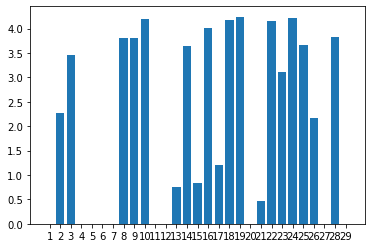

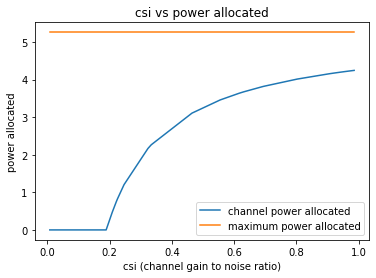

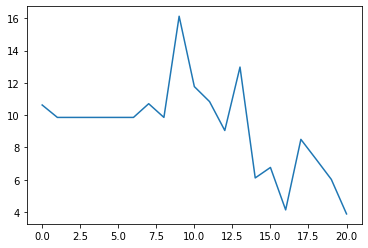

21
Power Allocated= 0
CSI= 0.09594027276214634
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.498181389168355
CSI= 0.3691668585740381
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.576901917804604
CSI= 0.6134661933578494
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.410466547099046
CSI= 0.5566326255644393
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9539149954885726
CSI= 0.7980409070772073
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 1.651130
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 0.971738


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform


Power Allocated= 2.19646265503199
CSI= 0.4973835294288653
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 1.793802
Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 1.177704

Power Allocated= 0
CSI= 0.17262270632974874
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5624127359004185
CSI= 0.6080613649611091
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 1.760188
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 1.598962

Power Allocated= 2.704086772240169
CSI= 0.6653816724764626
SNR= 10.495509422151986
Client: client10
Model client10 Train Epoch: 1 [0/384 (0%)]	Loss: 1.747475
Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 0.930684

Power Allocated= 2.5708815074127207
CSI= 0.6112088047275019
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 1.785984
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 1.2

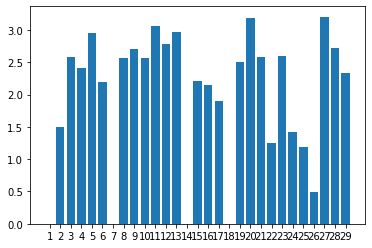

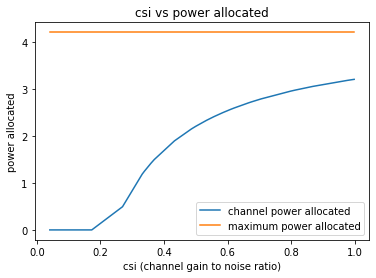

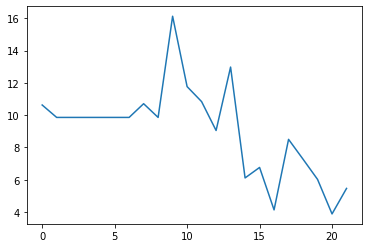

22
Power Allocated= 3.2080635139764113
CSI= 0.7392447892463118
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.338910286864696
CSI= 0.8184075466875145
SNR= 7.693212254323608
Client: client2
Model client2 Train Epoch: 1 [0/384 (0%)]	Loss: 0.880908
Model client2 Train Epoch: 2 [0/384 (0%)]	Loss: 0.800471


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 1.6282818036620545
CSI= 0.34100438624452245
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1949206232313734
CSI= 0.732131535787931
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7071012200694327
CSI= 0.25949127061051813
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 1.437981
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 0.902392

Power Allocated= 3.5355114944193087
CSI= 0.9753396029191059
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.717537768598933
CSI= 0.5425177584996602
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.159307835024807
CSI= 0.41640856836094964
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real



Power Allocated= 0
CSI= 0.13992455400596782
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.19513091756599288
SNR= 11.523803357394542
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3274354462496345
CSI= 0.810793308761963
SNR= 11.535836537278499
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1398025163444125
CSI= 0.7037332907074506
SNR= 12.131396295549962
Client: client16
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.329916913300803
CSI= 0.8124278786226745
SNR= 16.19816914861419
Client: client17
Model client17 Train Epoch: 1 [0/384 (0%)]	Loss: 0.969049
Model client17 Train Epoch: 2 [0/384 (0%)]	Loss: 0.967716

Power Allocated= 2.625373449489887
CSI= 0.5166831957918879
SNR= 16.64600190538016
Client: client18
Model client18 Train Epoch: 1 [0/384 (0%)]	Loss: 0.757864
Model client18 T

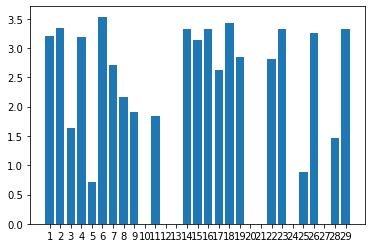

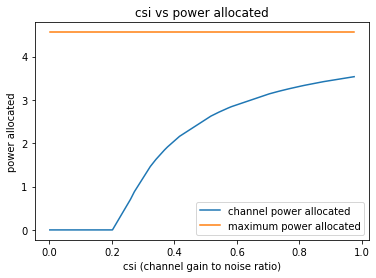

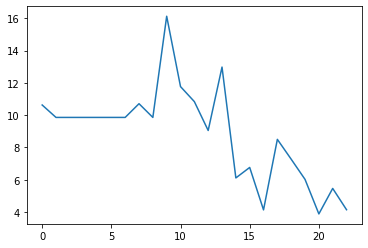

23
Power Allocated= 3.160212894470989
CSI= 0.45336146692979173
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.69761821943971
CSI= 0.37476481530155525
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.4921125770109196
CSI= 0.20517678328205247
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.7897469352652005
CSI= 0.6344326555459733
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.128944303666773
CSI= 0.3089266782740876
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.16633678353586556
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4328903084414435
CSI= 0.5173123621329655
S

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 1.528832

Power Allocated= 3.1255698216375594
CSI= 0.4463511497242528
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2834384482200885
CSI= 0.48018748549054546
SNR= 11.414721836905116
Client: client12
Model client12 Train Epoch: 1 [0/384 (0%)]	Loss: 1.511059
Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 1.167796

Power Allocated= 1.2911734130873187
CSI= 0.24541172429666258
SNR= 11.43683245745521
Client: client13
Model client13 Train Epoch: 1 [0/384 (0%)]	Loss: 1.304421
Model client13 Train Epoch: 2 [0/384 (0%)]	Loss: 0.742449

Power Allocated= 0
CSI= 0.16954650748467914
SNR= 11.523803357394542
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.7689200459873544
CSI= 0.6261590539961422
SNR= 11.535836537278499
Client: client15
Model client15 Train Epoch: 1 [0/384 (0%)]	Loss: 1.437457
Model client15 Train Epoch: 2 [0/384 (0

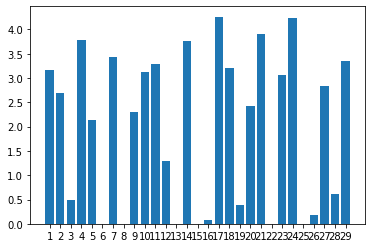

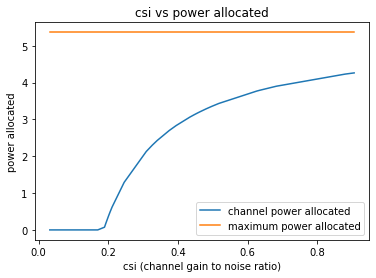

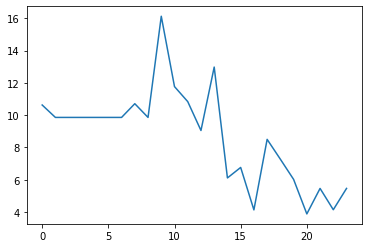

24
Power Allocated= 2.243784875411287
CSI= 0.4866010439761902
SNR= 7.13220226641212
Client: client1
Model client1 Train Epoch: 1 [0/384 (0%)]	Loss: 1.205920
Model client1 Train Epoch: 2 [0/384 (0%)]	Loss: 1.601608


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad
/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_


Power Allocated= 0
CSI= 0.1844327622687969
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6378017480314595
CSI= 0.6020271133773485
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8764199945039577
CSI= 0.7030190755118811
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0742030079009153
CSI= 0.8165575022210261
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 1.317198
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 0.967929

Power Allocated= 3.0293085966911573
CSI= 0.7876819725421863
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.330439839862212
CSI= 0.3368799306458149
SNR= 10.206599642321356
Client: client8
Model client8 Train Epoch: 1 [0/384 (0%)]	Loss: 1.875118
Model clie

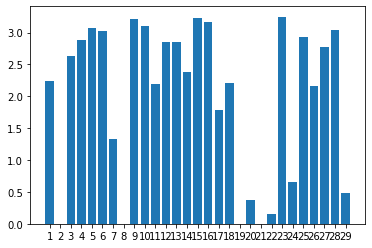

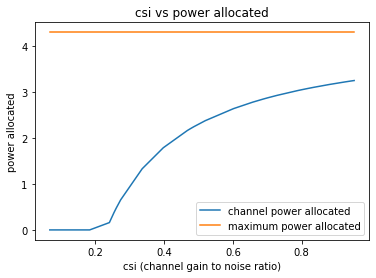

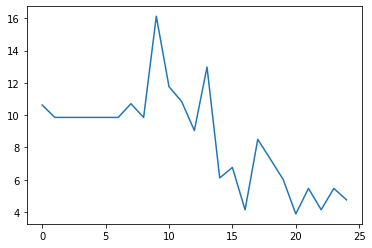

25
Power Allocated= 0
CSI= 0.18819475934068264
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3932329364168234
CSI= 0.43165983970541144
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5978197529180447
CSI= 0.8992384127678887
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.6832799510205017
CSI= 0.9740968739221019
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.317546475161023
CSI= 0.7182229012526914
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.289446327955871
CSI= 0.704014364199071
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 1.172679


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 0.945535

Power Allocated= 0
CSI= 0.1809510558373303
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.590487406163982
CSI= 0.8933480972029946
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 1.221379
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 0.841052

Power Allocated= 0
CSI= 0.21096477018227067
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.1988899974859697
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.6989928809037855
CSI= 0.9892380685846215
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.2676740210872373
CSI= 0.40946723118596773
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for

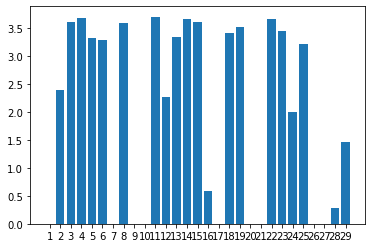

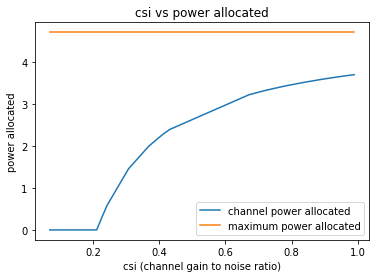

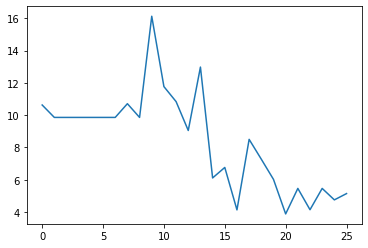

26
Power Allocated= 3.5566642095110015
CSI= 0.8827002037322945
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.6386031799794285
CSI= 0.9515214123863297
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.008223346814551058
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.900304629793451
CSI= 0.5588943128461659
SNR= 8.031758123585778
Client: client4
Model client4 Train Epoch: 1 [0/384 (0%)]	Loss: 1.443877
Model client4 Train Epoch: 2 [0/384 (0%)]	Loss: 0.899034


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform


Power Allocated= 0
CSI= 0.09008063681328227
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.03275400718984678
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.416005264785144
CSI= 0.43984147137237084
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3957129293153847
CSI= 0.772893840404821
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.451321083158837
CSI= 0.4467814897717437
SNR= 10.495509422151986
Client: client10
Model client10 Train Epoch: 1 [0/384 (0%)]	Loss: 1.484825
Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 0.971781

Power Allocated= 3.3697638958598124
CSI= 0.7576975729589436
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated=

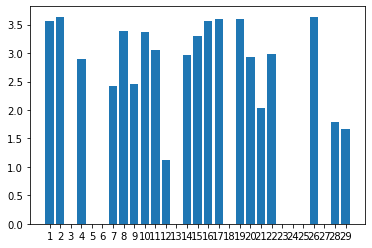

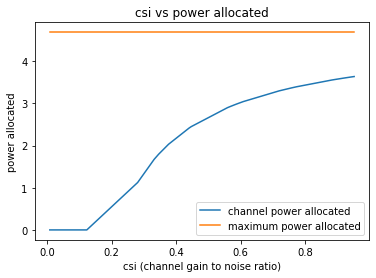

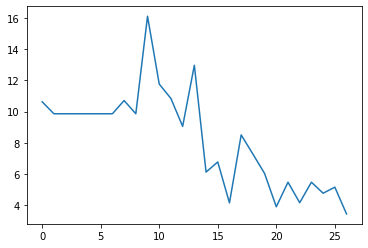

27
Power Allocated= 2.956996467425793
CSI= 0.6480677558727508
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.17685692265972142
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6073688839709792
CSI= 0.3457006452616842
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.3721248480552868
CSI= 0.31970125555611706
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.470617432891615
CSI= 0.9714136589244691
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.9799758295366603
CSI= 0.28408532657908503
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 1.969207


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 1.130307

Power Allocated= 3.4192523764212694
CSI= 0.9252468769374603
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8152284518205777
CSI= 0.5935364303094293
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.0026679914170019137
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.050712901495725
CSI= 0.6899729887451214
SNR= 10.574175352439738
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9802109743066127
CSI= 0.6579665824019327
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07965776885484821
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allo

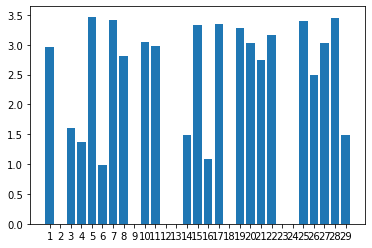

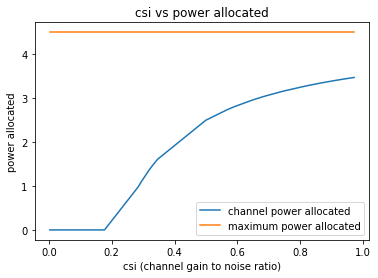

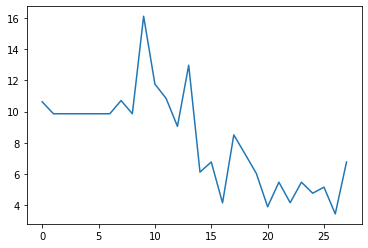

28
Power Allocated= 0.9673822516489712
CSI= 0.2729604993442798
SNR= 7.13220226641212
Client: client1
Model client1 Train Epoch: 1 [0/384 (0%)]	Loss: 1.951155
Model client1 Train Epoch: 2 [0/384 (0%)]	Loss: 1.171825


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad



Power Allocated= 0.8818950473632334
CSI= 0.26673630633651757
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5932553994402334
CSI= 0.9637062485571365
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4969774110715264
CSI= 0.8818819766879175
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3957799532893542
CSI= 0.809627414374424
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.288760871255745
CSI= 0.7450703589857853
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1921435869266395
CSI= 0.2908014492609874
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.02335940099238054
S

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 1.128102

Power Allocated= 0
CSI= 0.08832237061190906
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2446179605476435
CSI= 0.721345608963627
SNR= 11.523803357394542
Client: client14
Model client14 Train Epoch: 1 [0/384 (0%)]	Loss: 1.816588
Model client14 Train Epoch: 2 [0/384 (0%)]	Loss: 1.803294

Power Allocated= 0.31877891400969816
CSI= 0.23190357383713422
SNR= 11.535836537278499
Client: client15
Model client15 Train Epoch: 1 [0/384 (0%)]	Loss: 1.915582
Model client15 Train Epoch: 2 [0/384 (0%)]	Loss: 1.265337

Power Allocated= 0
CSI= 0.034425096021446944
SNR= 12.131396295549962
Client: client16
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3919126321092707
CSI= 0.8071003112680889
SNR= 16.19816914861419
Client: client17
Model client17 Train Epoch: 1 [0/384 (0%)]	Loss: 1.863376
Model client17 Train Epoch: 2 [0/384 (0%)]	Loss: 1.43144

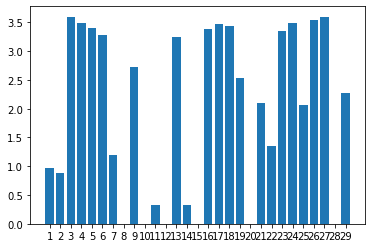

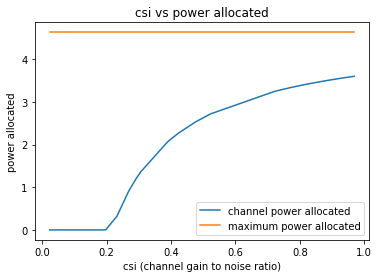

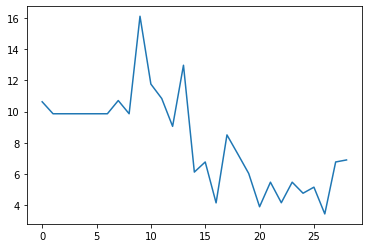

29
Power Allocated= 1.7789057684893623
CSI= 0.41040956325033173
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.12342446018210773
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.16116608173666414
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.135844232955032
CSI= 0.9262244352452782
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9618077629601722
CSI= 0.7976463683090561
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.646233566441709
CSI= 0.6372419769771842
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 1.662159


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 0.997858

Power Allocated= 2.333486645588126
CSI= 0.5313469407410548
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.459935140198832
CSI= 0.56961847893635
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.5243710281580483
CSI= 0.2709201024687764
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.7411431349249282
CSI= 0.4041460488015516
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 1.157875
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 0.817485

Power Allocated= 1.3192644552037347
CSI= 0.3452762418827715
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.990047629683441
CSI= 0.816027741744512
SNR= 11.43683245745521
Clien

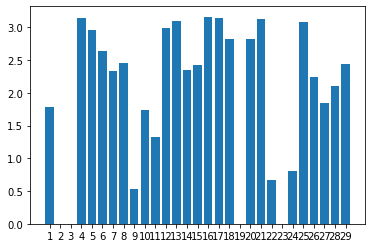

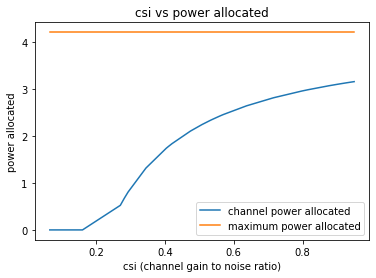

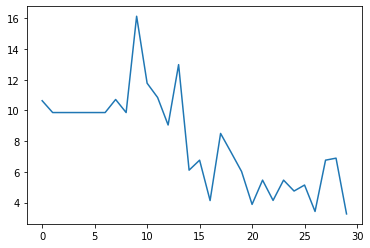

30
Power Allocated= 2.9480794617508055
CSI= 0.8369840874529082
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6790926008672837
CSI= 0.6831755093509828
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2227263572068109
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.340908271346631
CSI= 0.5549583479787819
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3572982811192995
CSI= 0.5600524578617772
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13145997909859675
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0152258591220193
CSI= 0.8868240102010349
SNR= 10.2065996423

/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 1.431495

Power Allocated= 1.2616468778066876
CSI= 0.3470777958783845
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 1.765490
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 0.822423

Power Allocated= 2.598159274383035
CSI= 0.6473807488579026
SNR= 11.414721836905116
Client: client12
Model client12 Train Epoch: 1 [0/384 (0%)]	Loss: 1.424448
Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 0.632047

Power Allocated= 3.101933626848888
CSI= 0.9606963010204178
SNR= 11.43683245745521
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4445458351237508
CSI= 0.37060378610131517
SNR= 11.523803357394542
Client: client14
Model client14 Train Epoch: 1 [0/384 (0%)]	Loss: 1.317445
Model client14 Train Epoch: 2 [0/384 (0%)]	Loss: 0.674805

Power Allocated= 3.0281456234545523
CSI= 0.8971026147382269
SNR= 11.535836537278499
Client: client15
Poor Channel, client not ta

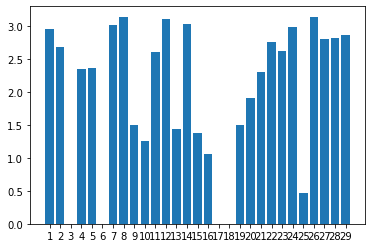

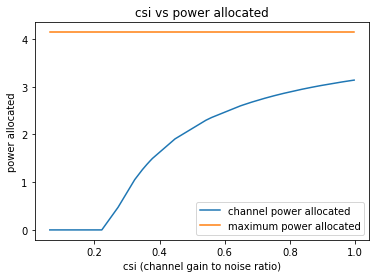

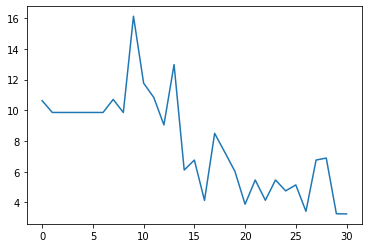

31
Power Allocated= 0
CSI= 0.10729832195840694
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3668071961806874
CSI= 0.50133550322604
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2860899229490963
CSI= 0.929895641059675
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6921555142788463
CSI= 0.37462669860813713
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.026179870549338347
CSI= 0.23066456885378883
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 3.448091


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 1.812109

Power Allocated= 3.2052370974817457
CSI= 0.8648706122164919
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1540802560863783
CSI= 0.4530218272928076
SNR= 10.206599642321356
Client: client8
Model client8 Train Epoch: 1 [0/384 (0%)]	Loss: 0.701204
Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 1.162556

Power Allocated= 3.314464929364621
CSI= 0.9550966245920304
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 0.719041
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 0.812708

Power Allocated= 2.323309422192844
CSI= 0.4906362099869984
SNR= 10.495509422151986
Client: client10
Model client10 Train Epoch: 1 [0/384 (0%)]	Loss: 0.535397
Model client10 Train Epoch: 2 [0/384 (0%)]	Loss: 0.647888

Power Allocated= 2.314829223551676
CSI= 0.4886032819658699
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 

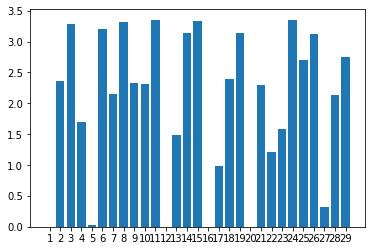

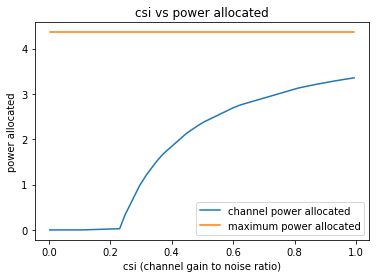

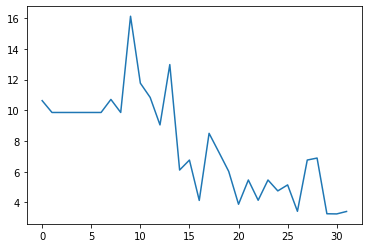

32
Power Allocated= 2.729954706592709
CSI= 0.5392994907436489
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13104122387448103
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2832500889611893
CSI= 0.7686620273270588
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2607912711931135
CSI= 0.7556176187267862
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4840968759843056
CSI= 0.4761643783061805
SNR= 8.333681916433473
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6402054175051672
CSI= 0.33967315657187225
SNR= 9.217576437049779
Client: client7
Model client7 Train Epoch: 1 [0/384 (0%)]	Loss: 0.587331


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client7 Train Epoch: 2 [0/384 (0%)]	Loss: 0.354958

Power Allocated= 3.464969481350848
CSI= 0.8934614318180364
SNR= 10.206599642321356
Client: client8
Model client8 Train Epoch: 1 [0/384 (0%)]	Loss: 0.404236
Model client8 Train Epoch: 2 [0/384 (0%)]	Loss: 0.912847

Power Allocated= 0
CSI= 0.0518085105918179
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.211751291043625
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4570306319882533
CSI= 0.3197767863915506
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 0.389093
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 0.969846

Power Allocated= 1.8707817363254096
CSI= 0.36853720656956446
SNR= 11.414721836905116
Client: client12
Model client12 Train Epoch: 1 [0/384 (0%)]	Loss: 0.276813
Model client12 Train Epoch: 2 [0/384 (0%)]	Loss: 0.980644

Power

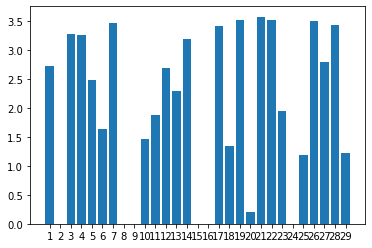

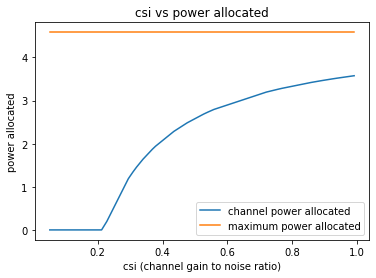

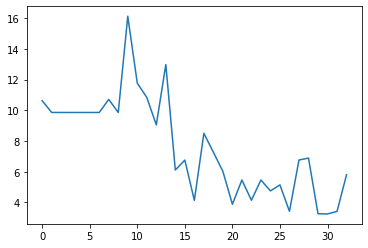

33
Power Allocated= 1.2651912062409858
CSI= 0.3350417619340018
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.228226187174298
CSI= 0.49464116508265676
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2097211553903422
SNR= 7.839881799697711
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9970697900858583
CSI= 0.4438873239162753
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9955950448582476
CSI= 0.7972582557748591
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 0.662625
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 0.441209


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform


Power Allocated= 0
CSI= 0.05706696443647008
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.05311048477543201
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.707447332375817
CSI= 0.64832073701331
SNR= 10.228036385508574
Client: client9
Model client9 Train Epoch: 1 [0/384 (0%)]	Loss: 0.659199
Model client9 Train Epoch: 2 [0/384 (0%)]	Loss: 1.093702

Power Allocated= 0
CSI= 0.17291725893382925
SNR= 10.495509422151986
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1079730712516906
CSI= 0.46687069632479294
SNR= 10.574175352439738
Client: client11
Model client11 Train Epoch: 1 [0/384 (0%)]	Loss: 0.525128
Model client11 Train Epoch: 2 [0/384 (0%)]	Loss: 0.323375

Power Allocated= 3.1002333259993504
CSI= 0.8698220594646108
SNR= 11.414721836905116
Client: client12
Poor Channel, client not taken for 

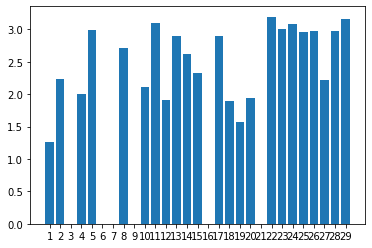

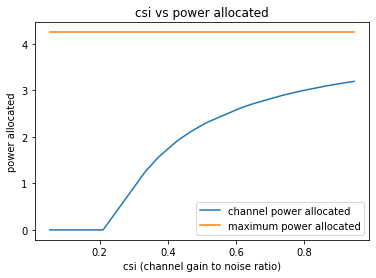

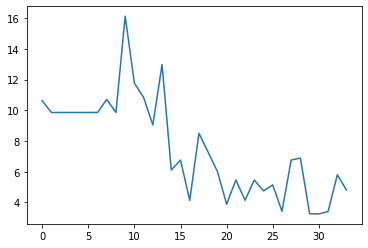

34
Power Allocated= 0
CSI= 0.00741655241343997
SNR= 7.13220226641212
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3410662324955367
CSI= 0.4525364867121565
SNR= 7.693212254323608
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.8870644489266306
CSI= 0.27294302027885764
SNR= 7.839881799697711
Client: client3
Model client3 Train Epoch: 1 [0/384 (0%)]	Loss: 1.158488


/tmp/ipykernel_488003/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inform

Model client3 Train Epoch: 2 [0/384 (0%)]	Loss: 0.445630

Power Allocated= 2.170045996822699
CSI= 0.4200292095268734
SNR= 8.031758123585778
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.235208713436304
CSI= 0.4318490228032359
SNR= 8.333681916433473
Client: client5
Model client5 Train Epoch: 1 [0/384 (0%)]	Loss: 0.786052
Model client5 Train Epoch: 2 [0/384 (0%)]	Loss: 0.403163

Power Allocated= 0
CSI= 0.16885903990783202
SNR= 9.217576437049779
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.534278845445185
CSI= 0.9837156140657989
SNR= 10.206599642321356
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3172879343676964
CSI= 0.8106717687476893
SNR= 10.228036385508574
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4106919905158914
CSI= 0.8770846456628857
SNR= 10.495509422151986
Client: client10
Poor Cha

KeyboardInterrupt: 

In [10]:
for fed_round in range(args.rounds):
    
    client_good_channel=[] #to check which clients have a good channel, only those will be taken for averaging per round

    # Training 
    #even slot
    
    snr=[] #snr of the channel
    csi=[] #csi of the channel
    for ii in range (int(args.clients)-1):
        #snr.append(random.uniform(args.snr_low, args.snr_high))
        csi.append(random.uniform(args.csi_low,args.csi_high))
    
    # if(fed_round==0):
    #     snr,cluster_head=get_cluster()
    if(fed_round==0): #fed_round==0 or True                                        %%%static or moving
        snr,cluster_head=get_cluster()
        temp=copy.deepcopy(cluster_head)
        temp1=copy.deepcopy(snr)
    else:
        #print(temp)
        cluster_head=copy.deepcopy(temp)
        snr=copy.deepcopy(temp1)
    #print(cluster_head)
    smallmu1=0
    gsmall1=3.402823466E+38 
    
    #water filling algorithm
    mu=1e-15
    while(mu<=1):
        #print("yay")
        #pn=max(1/mu-1/csi,0)
        g1=0
        pn1=0
        for jj in csi:
            pn=max(1/mu-1/jj,0)
            g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
            pn1+=pn
        g=g1-mu*(pn1-P*(int(args.clients)-1))
        if(g<gsmall1):
            smallmu1=mu
            gsmall1=g
        mu+=0.00002

    #print(smallmu1)
    # poptim=max(1/smallmu1-1/csi1,0)
    # print(poptim)
    index=0
    members=[]
    for i in clients:
        if(i['hook'].id!=cluster_head):
            members.append(i)
        else:
            head=i
    for client in members:
        goodchannel=ClientUpdate(args, device, client,key_np,key,snr[index],csi[index],smallmu1)
        if(goodchannel):
            client_good_channel.append(client)
        index+=1
        
    po=[]    
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    
    plt.bar([str(i) for i in range (1,len(po)+1)],po,)
    csi.sort()
    po=[]
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    fig,ax=plt.subplots()
    line1=ax.plot(csi,po,label="channel power allocated")
    line2=ax.plot(csi,[1/smallmu1]*len(csi),label="maximum power allocated")
    ax.set_title("csi vs power allocated")
    ax.set_xlabel("csi (channel gain to noise ratio)")
    ax.set_ylabel("power allocated")
    ax.legend()
    #plt.show()
    

#     # Testing 
#     for client in active_clients:
#         test(args, client['model'], device, client['testset'], client['hook'].id)
    
    
    
    print()
    print("Clients having a good channel and considered for training")
    for no in range (len(client_good_channel)):
        print(client_good_channel[no]['hook'].id)
        
        
        
    # Averaging 
        #odd slot

    head['model'] = averageModels(head['model'],client_good_channel)
    # Testing the average model
    #test(args, global_model, device, global_test_loader, 'Global')
    ac=test(args, head['model'], device, global_test_loader, 'Final')
    accuracy.append(ac)
    
    print("Power in training Round=",sum(po))
    #print("Power cap=",P*len(active_clients))
    
    #print("Total Power =",power_odd+power_even)
    print()
            
    # Share the global model with the clients
    index=0
    for client in members:
        client['model'].load_state_dict(head['model'].state_dict())
        #client=CLientReturn(client,snr[index],csi[index],smallmu1) #CHANGE:Commented
        index+=1
        #client['model']=torch.quantization.quantize_dynamic(client['model'],{torch.nn.Conv2d},dtype=torch.qint8)
        #print(client['model'].conv1.weight.data)
    fig1,ax1=plt.subplots()
    ax1.plot([i for i in range(len(accuracy))],accuracy)
    plt.show()
    print(rc)
    rc+=1

In [ ]:
print(accuracy)